# Dimensionality Reduction

* Curse of Dimensionality
* Dimensionality Reduction Approaches
    * Projection
    * Manifolds
* Dimensionality Reduction Techniques
    * PCA
    * Kernel PCA
    * LLE
    * Others

### Curse of Dimensionality
As the dimensions increase, the chances of being on the edge increases.

In [72]:
# Area of the edge 1m
1 - (0.998)**2

0.0039959999999999996

In [73]:
# Volume of the edge 1m
1 - (0.998)**3

0.005988007999999989

In [74]:
# and for 10000 dimentions
1 - (0.998)**10000

0.999999997979714

In [75]:
import numpy as np
import numpy.random as rnd

### Dimension Reduction Approaches: Projection

* Most dataset features are concentrated in a few dimensions - not uniformly across all. Much learnable training can be found in low-D subspace.

#### Build a 3D dataset

In [76]:
rnd.seed(4)
m = 60 # No of instances
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * rnd.randn(m)

# mean-normalize the data
X = X - X.mean(axis=0)

# apply PCA -(projection-based dimension reduction technique) to reduce to 2D
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) #n_components denote the number of axes the dataset has to be reduced to
X2D = pca.fit_transform(X)

# recover 3D points projected on 2D plane
X2D_inv = pca.inverse_transform(X2D)

#### Utility to draw 3D arrows

In [77]:
# Utility to draw the arrows
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# express plane as function of x,y
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

#### plot 3D dataset, plane & projections

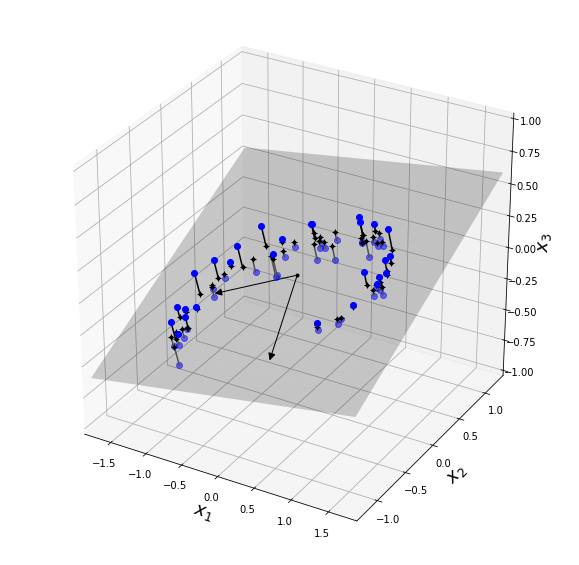

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X2D_inv[:, 2]] # ones above the identified plane
X3D_below = X[X[:, 2] <= X2D_inv[:, 2]] # ones below the identified plane

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5) # plotting the ones below the identified plane

ax.plot_surface(x1, x2, z, alpha=0.2, color="k") # plotting the identified plane
np.linalg.norm(C, axis=0)

# plotting the projection arrows
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X2D_inv[i, 2]:
        ax.plot([X[i][0], X2D_inv[i][0]], [X[i][1], X2D_inv[i][1]], [X[i][2], X2D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X2D_inv[i][0]], [X[i][1], X2D_inv[i][1]], [X[i][2], X2D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X2D_inv[:, 0], X2D_inv[:, 1], X2D_inv[:, 2], "k+") # Plotting the projections
ax.plot(X2D_inv[:, 0], X2D_inv[:, 1], X2D_inv[:, 2], "k.") # Plotting the projections
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo") # Plotting the instances above the identified plane
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

#save_fig("dataset_3d_plot")
plt.show()

#### Plot 2D projection equivalent:

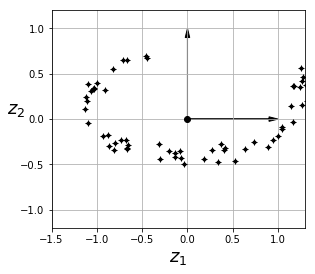

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "k+") # plotting the projections
ax.plot(X2D[:, 0], X2D[:, 1], "k.") # plotting the projections
ax.plot([0], [0], "ko") # Plotting the origin
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k') # plotting the z1 arrow 
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k') # plotting the z2 arrow
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

#### Switch to the slides

### Projection for Swiss roll

In [80]:
from sklearn.datasets import make_swiss_roll
help(make_swiss_roll)

Help on function make_swiss_roll in module sklearn.datasets.samples_generator:

make_swiss_roll(n_samples=100, noise=0.0, random_state=None)
    Generate a swiss roll dataset.
    
    Read more in the :ref:`User Guide <sample_generators>`.
    
    Parameters
    ----------
    n_samples : int, optional (default=100)
        The number of sample points on the S curve.
    
    noise : float, optional (default=0.0)
        The standard deviation of the gaussian noise.
    
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    
    Returns
    -------
    X : array of shape [n_samples, 3]
        The points.
    
    t : array of shape [n_samples]
        The univariate position of the sample according to 

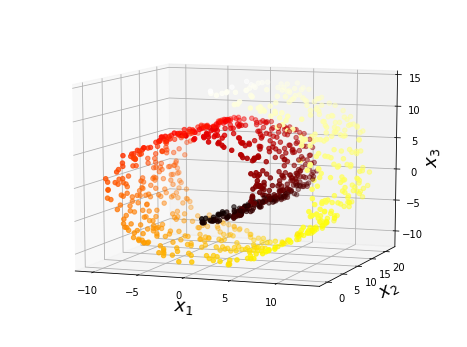

In [81]:
# Swiss roll visualization:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# cmap chooses the color map
# color of the indexes are set based on the univariate position of the instance
# a univariate position based on the main axis (which is along the swiss roll plane)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [82]:
print(X[0:5,:])
print(t[0:5])

[[ -3.29677117   4.26198454   7.69787682]
 [  5.95972743  11.45784273  12.72625276]
 [  6.66051523  18.15820401  -9.84713337]
 [ -6.11824123  15.48364843  -8.30589399]
 [  6.33443886  16.41063456  -0.4913301 ]]
[  8.24234644  13.67266022  11.61126935  10.35461227   6.18283002]


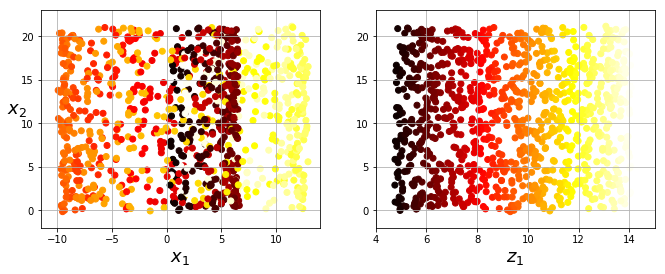

In [83]:
# "squashed" swiss roll visualization:
# Projecting on x1 and x2
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

# Plotting x2 versus the univariate label
# hence, the coloring is linear in the second curve and changes with the univariate label
plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

#### Switch to the slides

### Approaches: Manifolds
* Manifolds = shapes that can be bent/twisted in higher-D space.
* ex: "Swiss roll" problem

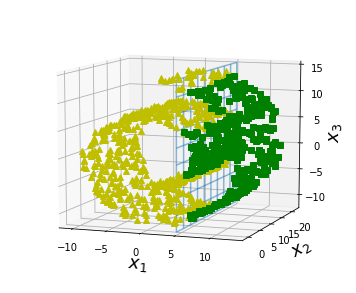

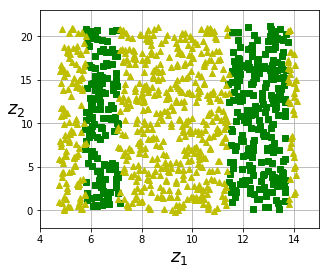

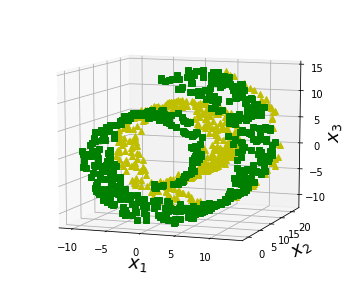

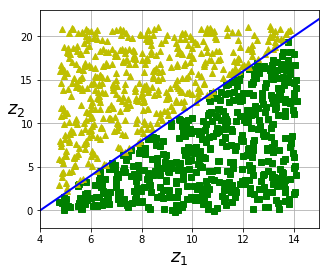

In [84]:
from matplotlib import gridspec

# Plotting the axes
axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

# X contains the make_swiss_swiss roll data
# Defining Case 1
positive_class = X[:, 0] > 5 # Potive class x1 > 5 for case 1
X_pos = X[positive_class]
X_neg = X[~positive_class]

# Plotting Case 1
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

# Plotting x2 versus t (univariate variable along the rolled plane)
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
plt.plot(t[positive_class], X[positive_class, 1], "gs") # plotting the positive class
plt.plot(t[~positive_class], X[~positive_class, 1], "y^") # plotting the negative class
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# defining case 2 where the decision boundary is a function of the univariate vvariable t
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')
positive_class = 2 * (t[:] - 4) > X[:, 1] # defining the postive class as a function of univariate variable t
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^") # plotting the positive class
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs") # plotting the negative class
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# Lesson learned (below):
# Unrolling a dataset to a lower dimension doesn't necessarily lead to
# a simpler representation.

#### Switch back to the slides

### PCA (Principal Component Analysis)
Most popular projection-baed dimensionality reduction algorithm
* Finds hyperplane that lies closest to the data
* Project data onto the hyperplane

### Preserving Variance
* Below: simple 2D dataset projected onto 3 different axes.
* Projection on solid line preserves the maximum variance. (Therefore less likely to lose information.)

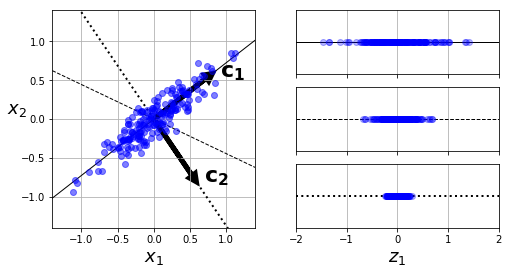

In [85]:
angle = np.pi / 5 # defining an angle of 36 degrees
stretch = 5
m = 200

rnd.seed(3)
X = rnd.randn(m, 2) / 10 # Generating 200 * 2 normalized random numbers in the range and strething it 5 times along the x axis
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretching by multpliying thr x1 axis by 5 times
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # projection along 36 degrees and 54 degrees

u1 = np.array([np.cos(angle), np.sin(angle)]) # array to rotate a an array by 36 degrees
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)]) # array to rotate an array by -24 degrees
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)]) # array to rotate an array by -54 degrees

X_proj1 = X.dot(u1.reshape(-1, 1)) # projection along 36 degrees angle
X_proj2 = X.dot(u2.reshape(-1, 1)) # projection along -24 degrees angle
X_proj3 = X.dot(u3.reshape(-1, 1)) # projection along -54 degrees angle

# Plotting the dataset, the hyperplanes, 
plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1) # plotting hyper plane 1
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1) # plotting hyper plane 2
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2) # plotting hyper plane 3
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5) # Plotting the datasets
plt.axis([-1.4, 1.4, -1.4, 1.4]) # Making the axis
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k') # plotting the unit vector along first hyperplane
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k') # plotting the unit vector along third hyperplane
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

# PLotting the projections along the hyperplanes 
## Projection 1
plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

## Projection 2
plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

## Projection 3
plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

### Principal Components
* PCA finds axis responsible for largest amount of variance in dataset.
* Also finds 2nd axis, responsible for next largest amount.
* If higher-D dataset, PCA also finds 3rd axis...
* Repeat for # of dimensions in the dataset.
* Each axis vector is called a **principal component**. (PC)

* PCs found using **Singular Value Decomposition (SVD)**, a matrix factorization technique.
* SVD decomposes training set matrix X into dot product of three matrices.
* Note: PCA assumes data is centered around origin. Scikit PCA will adjust data for you if needed.

In [86]:
# use NumPy svd() to get principal components of training set,
# then extract 1st two PCs.

# Centralizing the dataset
X_centered = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X_centered)

# Extracting the first 2 components
c1, c2 = V.T[:,0], V.T[:,1]
print(c1,c2)
print(c1)
print(c2)

[-0.79644131 -0.60471583] [-0.60471583  0.79644131]
[-0.79644131 -0.60471583]
[-0.60471583  0.79644131]


### Projecting Training Data Down to d Dimensions
* Done by computing dot product of training data (X) by matrix containing the first d principal components (Wd).

#### Projecting a point onto an axis - What is projecction? Revision from linear algebra
The dot product is also very useful to project points onto an axis. The projection of vector $\textbf{v}$ onto $\textbf{u}$'s axis is given by this formula:

$\textbf{proj}_{\textbf{u}}{\textbf{v}} = \dfrac{\textbf{u} \cdot \textbf{v}}{\left \Vert \textbf{u} \right \| ^2} \times \textbf{u}$

Which is equivalent to:

$\textbf{proj}_{\textbf{u}}{\textbf{v}} = (\textbf{v} \cdot \hat{\textbf{u}}) \times \hat{\textbf{u}}$

In [87]:
import numpy as np
u = np.array([2,5])
v = np.array([3, 1])

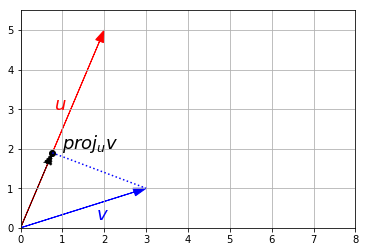

In [88]:
# Demonstrating projection in Linear Algebra 

# utility to plot an arrow in 2d space
def plot_vector2d(vector2d, origin=[0, 0], **options):
    return plt.arrow(origin[0], origin[1], vector2d[0], vector2d[1],
              head_width=0.2, head_length=0.3, length_includes_head=True,
              **options)


import numpy.linalg as LA
u_normalized = u / LA.norm(u) # Forming a unit vector out of the vector by divinding with the normal value
proj = v.dot(u_normalized) * u_normalized

plot_vector2d(u, color="r") # Plotting the vector u using the utility defined above
plot_vector2d(v, color="b") # Plotting the vector v using the utility defined above
plot_vector2d(proj, color="k", linestyle=":") # Plotting the projection

plt.plot(proj[0], proj[1], "ko") # Plotting the end point
plt.plot([proj[0], v[0]], [proj[1], v[1]], "b:") # plotting the perpendicular line

plt.text(1, 2, "$proj_u v$", color="k", fontsize=18)
plt.text(1.8, 0.2, "$v$", color="b", fontsize=18)
plt.text(0.8, 3, "$u$", color="r", fontsize=18)

plt.axis([0, 8, 0, 5.5])
plt.grid()
plt.show()

#### Original 2d problem

In [89]:
# project training set onto plane defined by 1st two PCs.
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)
print(X2D) # returns a 2 dimensional dataset

[[ -8.96088137e-01   2.61576283e-02]
 [ -4.53603363e-02  -1.85948860e-01]
 [  1.38359166e-01  -3.11666166e-02]
 [  4.16315780e-02  -6.04371773e-02]
 [  2.18583744e-02  -4.58726693e-02]
 [  6.53868464e-01   1.03673047e-01]
 [ -4.45218566e-01   1.63002740e-01]
 [ -2.52100754e-02  -3.96098381e-02]
 [  2.74828447e-01  -1.47486328e-01]
 [ -4.89804685e-01  -1.19064333e-01]
 [  5.91772943e-01  -6.68825324e-03]
 [ -7.44460369e-01   9.37220434e-03]
 [  5.12230114e-01  -5.91117152e-02]
 [ -3.13266691e-01  -2.12641588e-02]
 [  3.83765553e-01  -1.35145070e-02]
 [ -3.77664930e-01   1.91087392e-01]
 [  6.22192127e-01  -4.81326634e-02]
 [  4.05843018e-01  -2.32002753e-01]
 [  4.62900292e-01  -9.12474313e-02]
 [ -5.62638042e-01  -2.36637544e-02]
 [  8.09046208e-01   8.31463215e-02]
 [  1.80719622e-01  -1.69142171e-01]
 [  2.98447518e-01  -5.11785151e-02]
 [  4.35729072e-01   1.35618235e-02]
 [  1.12339132e+00  -1.68707469e-03]
 [ -5.09329756e-01   7.59538223e-02]
 [ -5.57383436e-01   1.01605408e-01]
 

### Scikit PCA
* Uses SVD decomposition as before.
* You can access each PC using *components_* variable. (

In [90]:
# Calculating PCA directly using PCA class of sklearn.decomposition
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) # Specifying the number of principal components to consider
X2D = pca.fit_transform(X)

print(pca.components_[0]) # Printing the first principal component
print(pca.components_.T[:,0]) # printing the second principal components

[-0.79644131 -0.60471583]
[-0.79644131 -0.60471583]


#### Switch to slides

### Explained Variance Ratio
* Very useful metric: proportion of dataset's variance along the axis of each PC component.

In [91]:
# 95% of dataset variance explained by 1st axis.
print(pca.explained_variance_ratio_)

[ 0.95369864  0.04630136]


### Choosing Right #Dimensions
* No need to choose arbitrary #dimensions. Instead pick d that cumulatively accounts for a sufficient amount, ex: 95%.

In [92]:
# find minimum d to preserve 95% of training set variance
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

1


#### Switch to slides

### PCA for Compression
* Example applying PCA to MNIST dataset with 95% preservation = results in ~150 features (original = 28x28 = 784)

In [93]:
#MNIST compression:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

X = X_train

pca = PCA()
pca.fit(X)
d = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
d

154

In [94]:
# Verifying the above result using the alternate form of calculating the number of components required
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
pca.n_components_

154

In [95]:
# did we hit our 95% minimum?
np.sum(pca.explained_variance_ratio_)

0.9503623084769206

#### Switch to slides

### Decompression of dataset using inverse transform

In [96]:
# use inverse_transform to decompress back to 784 dimensions
X_mnist = X_train

pca = PCA(n_components = 154)
X_mnist_reduced = pca.fit_transform(X_mnist)
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced) # Recovering the original dataset using inverse transform

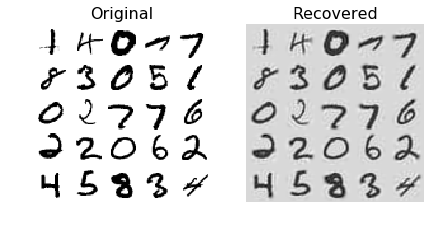

In [97]:
# Plotting the original dataset and the recovered MNIST dataset
import matplotlib
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_mnist_recovered[::2100])
plt.title("Recovered", fontsize=16)
plt.show()

#### Switch to slides

### Incremental PCA
* PCA normally requires entire dataset in memory for SVD algorithm.
* **Incremental PCA (IPCA)** splits dataset into batches.

In [98]:
# split MNIST into 100 minibatches using Numpy array_split()
# reduce MNIST down to 154 dimensions as before.
# note use of partial_fit() for each batch.

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_mnist, n_batches):
    print(".", end="") # end= "" prints in the same line
    inc_pca.partial_fit(X_batch)

X_mnist_reduced_inc = inc_pca.transform(X_mnist)
print(np.sum(inc_pca.explained_variance_ratio_))

....................................................................................................0.94962142308


In [99]:
# alternative: Numpy memmap class (creates binary array on disk as if it was in memory)
# Creates a memory map
# memory mapped files are used to access small segments of large files on disk
# without reading the entire file into the memory
filename = "my_mnist.data"
# Making sure the file instance is free to be edited
try:
    del X_mm
except:
    pass

X_mm = np.memmap(
    filename, dtype='float32', mode='write', shape=X_mnist.shape)

X_mm[:] = X_mnist
print(X_mm.shape)
del X_mm

(52500, 784)


In [100]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=X_mnist.shape)
# each batch size would be the number of instances in MNIST dataset divided by the number of patches
batch_size = len(X_mnist) // n_batches 
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)
print(np.sum(inc_pca.explained_variance_ratio_))

0.949632


#### Switch to slides

### Randomized PCA
* Stochastic algorithm, quickly finds approximation of 1st d components. Dramatically faster.

In [101]:
rnd_pca = PCA(
    n_components=154, 
    random_state=42, 
    svd_solver="randomized")

X_reduced = rnd_pca.fit_transform(X_mnist)

In [102]:
# Calculating the time difference in time using regular_pca, inc_pca and rnd_pca for different number of principal components
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(
        n_components=n_components)
    inc_pca     = IncrementalPCA(
        n_components=154, 
        batch_size=500)
    rnd_pca     = PCA(
        n_components=154, 
        random_state=42, 
        svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_mnist)
        t2 = time.time()
        print(pca.__class__.__name__, t2 - t1, "seconds")

n_components = 2
PCA 1.87398099899292 seconds
IncrementalPCA 10.580116271972656 seconds
PCA 5.324152946472168 seconds
n_components = 10
PCA 1.9502267837524414 seconds
IncrementalPCA 11.896371603012085 seconds
PCA 4.5000834465026855 seconds
n_components = 154
PCA 4.275515794754028 seconds
IncrementalPCA 14.443388223648071 seconds
PCA 4.8228185176849365 seconds


In [103]:
# Again calculating the time needed for randomized PCA for 154 principal components
rnd_pca = PCA(n_components=154, svd_solver="randomized")

t1 = time.time()
X_reduced = rnd_pca.fit_transform(X_mnist)
t2 = time.time()
print(t2-t1, "seconds")

4.721549987792969 seconds


#### Switch to slides

### Kernel PCA
* Use kernel trick to map instances into higher-D feature spaces. This enables non-linear classification & regression with SVMs.
* Good at preserving clusters after projecton.

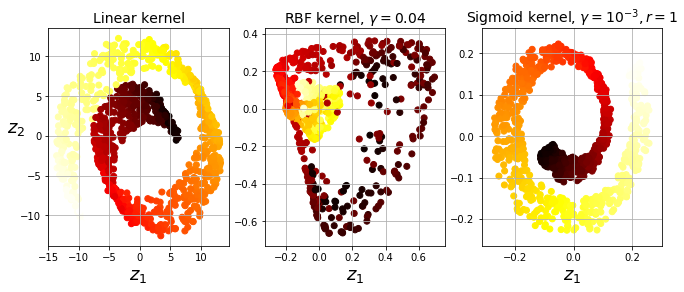

In [104]:
# Below: Swiss roll reduced to 2D using 3 techniques:
# 1) linear kernel (equiv to PCA)
# 2) RBF kernel
# 3) sigmoid kernel (logistic)

from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(
    n_samples=1000, 
    noise=0.2, 
    random_state=42)

lin_pca = KernelPCA(
    n_components = 2, 
    kernel="linear", 
    fit_inverse_transform=True) # Fit inverse is set to true to make sure that a pre-image is created

rbf_pca = KernelPCA(
    n_components = 2, 
    kernel="rbf", 
    gamma=0.0433, 
    fit_inverse_transform=True) # Fit inverse is set to true to make sure that a pre-image is created

sig_pca = KernelPCA(
    n_components = 2, 
    kernel="sigmoid", 
    gamma=0.001, 
    coef0=1, 
    fit_inverse_transform=True) # Fit inverse is set to true to make sure that a pre-image is created

y = t > 6.9

plt.figure(figsize=(11, 4))

for subplot, pca, title in (
    (131, lin_pca, "Linear kernel"), 
    (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
    (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("kernel_pca_plot")
plt.show()

#### Switch back to the slides

### Selecting a Kernel & Hyperparameters
* Dimensionality reduction = prep for supervised learning task
* Can use grid search to select kernel & params

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Forming a pipeline with Kernel PCA and a binary classifier using Logistic Regression
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]}] # Two kernels RBF and sigmoid to be grid-searched

# Using grid search to find the best kernel and PCA
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

# best kernel & params?
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


#### Switch back to the slides

### Reconstruction in Kernel PCA

In [106]:
rbf_pca = KernelPCA(
    n_components = 2, 
    kernel="rbf", 
    gamma=0.0433,
    fit_inverse_transform=True) # perform reconstruction

X_reduced  = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced) # Constructing the pre-image using the reduced image and inverse transform 

# Calculating the reconstruction pre-image error
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.786308795766097

#### Switch to slides

### LLE (Locally Linear Embedding)
* Powerful nonlinear dimensionality reduction tool
* Manifold Learning; doesn't rely on projections.
* LLE measures how each instance relates to closest neighbors, then looks for low-D representation where local relations are best preserved.

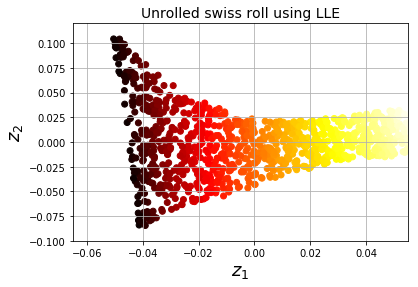

In [107]:
# Use LLE to unroll a Swiss Roll.

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import make_swiss_roll

# Forming the swiss roll
X, t = make_swiss_roll(
    n_samples=1000, 
    noise=0.2, 
    random_state=41)

# Inititalizing the LLE class, n_neighbours is the number of closest neighbours to consider
# n_components is the number of number of components it has to be reduced to
lle = LocallyLinearEmbedding(
    n_neighbors=10, 
    n_components=2, 
    random_state=42)

# Fitting the datset onto the LLE class
X_reduced = lle.fit_transform(X)

# Plotting the unrolled swiss roll  
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

#### Switch to slides

### MDS, Isomap, t-SNE, LDA

In [108]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [109]:
from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [110]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(X)

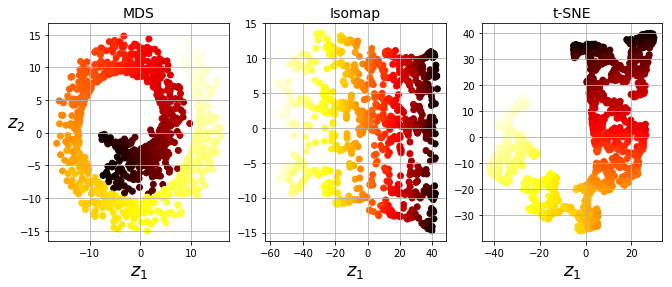

In [111]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("other_dim_reduction_plot")
plt.show()